In [1]:
import json
import os
import pandas as pd
import numpy as np
import prettytable as pt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings("ignore")


###################################################################################################
                                                                                                  #
from rhoova.Client import *                                                                       #   
#Register and get api key from https://app.rhoova.com/ for ClientConfig("api key", "api secret")  #
config = ClientConfig("", "")                                                                     #
api = Api(config)                                                                                 # 
                                                                                                  #
###################################################################################################


directory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
datadirectory=directory+"/data/yielddata.csv"


yielddata = pd.read_csv(datadirectory)
yielddata = yielddata.replace(np.nan, '', regex=True) 

mdirectory = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
mdatadirectory=mdirectory+"/data/marketdata.csv"

marketdata = pd.read_csv(mdatadirectory)
marketdata = marketdata.replace(np.nan, '', regex=True) 


/opt/homebrew/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
fixedleg={}
fixedleg["payOrReceive"]="Receive"
fixedleg["coupon"]= 0.085
fixedleg["frequency"]="Semiannual"
fixedleg["calendar"]="Turkey"
fixedleg["dateGeneration"]="Backward"
fixedleg["dayCounter"]="Actual360"
fixedleg["businessDayConvention"]="ModifiedFollowing"
fixedleg["maturityDateConvention"]="ModifiedFollowing"
fixedleg["endOfMonth"]=True
fixedleg

{'payOrReceive': 'Receive',
 'coupon': 0.085,
 'frequency': 'Semiannual',
 'calendar': 'Turkey',
 'dateGeneration': 'Backward',
 'dayCounter': 'Actual360',
 'businessDayConvention': 'ModifiedFollowing',
 'maturityDateConvention': 'ModifiedFollowing',
 'endOfMonth': True}

In [3]:
floatingleg={}
floatingleg["frequency"]="Quarterly"
floatingleg["spread"]=0.0
floatingleg["calendar"]="Turkey"
floatingleg["dateGeneration"]="Backward"
floatingleg["dayCounter"]="Actual360"
floatingleg["businessDayConvention"]="ModifiedFollowing"
floatingleg["maturityDateConvention"]="ModifiedFollowing"
floatingleg["endOfMonth"]=True
floatingleg["fixingDate"]=["2020-12-02"]
floatingleg["fixingRate"]=[0.0012428641149285805]
floatingleg

{'frequency': 'Quarterly',
 'spread': 0.0,
 'calendar': 'Turkey',
 'dateGeneration': 'Backward',
 'dayCounter': 'Actual360',
 'businessDayConvention': 'ModifiedFollowing',
 'maturityDateConvention': 'ModifiedFollowing',
 'endOfMonth': True,
 'fixingDate': ['2020-12-02'],
 'fixingRate': [0.0012428641149285805]}

In [4]:
instruments={}
depo={}
irs={}

depo["businessDayConvention"]="Following"     # if it is null, default value is used
depo["dayCounter"]="Actual360"                # if it is null, default value is used

irs["businessDayConvention"]="Following"      # if it is null, default value is used 
irs["dayCounter"]="Actual360"                 # if it is null, default value is used 
irs["frequency"]="Semiannual"               

instruments["DEPO"]=depo
instruments["IRS"]=irs

instruments

{'DEPO': {'businessDayConvention': 'Following', 'dayCounter': 'Actual360'},
 'IRS': {'businessDayConvention': 'Following',
  'dayCounter': 'Actual360',
  'frequency': 'Semiannual'}}

In [5]:
# Fix parameters for building yield curve
yieldcurveconfig={
      "name": "TRYZC",
      "settlementDays": 2,
      "intpMethod": "LINEAR",
      "currency": "TRY",
      "calendar": "Turkey",
      "dayCounter": "Actual360",
      "period": "6M",
      "instruments": instruments

    }
yieldcurveconfig

{'name': 'TRYZC',
 'settlementDays': 2,
 'intpMethod': 'LINEAR',
 'currency': 'TRY',
 'calendar': 'Turkey',
 'dayCounter': 'Actual360',
 'period': '6M',
 'instruments': {'DEPO': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360'},
  'IRS': {'businessDayConvention': 'Following',
   'dayCounter': 'Actual360',
   'frequency': 'Semiannual'}}}

In [6]:
riskdata = {
  "id": "PORTFOLIO1",
  "name": "PORTFOLIO 1",
  "method": "VaR",
  "forRisk": True,
  "valuationDate": "2021-01-28",
  "valuationCurrency": "TRY",
  "riskMethod": "HISTORICAL",
  "horizon": 252,
  "confidenceInterval": 0.99,
  "returnType": None,
  "trend": False,
  "calendar": "Turkey",
  "timeBucket": ["0D","1D","1W","2W","3W","1M","2M","3M","6M","9M","1Y","2Y","3Y","4Y",
                "5Y","6Y","7Y","8Y","9Y","10Y","12Y","15Y","20Y","25Y","30Y","40Y","50Y"],
  "fillNa": "BACKWARD",
  "maxFillNaDays": 5,
  "tasks": [
      {
      "trade_id": "IRS1000",
      "calculation_type": "interest_rates_swap",
      "discountCurve": "TRYZC",
      "floatingLegForecastCurve": "TRYZC",
      "settlementDate": "2021-02-01",
      "maturityDate": "2026-06-04",
      "startDate": "2021-02-01",
      "notional": 1000000,
      "currency": "TRY",
      "fixedLeg":fixedleg,
      "floatingLeg":floatingleg
    }
  ],
  "curves": [yieldcurveconfig],
  "yieldData": yielddata.to_dict('r'),
  "marketData":marketdata.to_dict('r'),
}

In [7]:
try:
    res = api.createTask(CalculationType.PORTFOLIO, riskdata, True)
    if(res["result"]):
      result=json.loads(res["result"])
    else:
      print(res["result"])
except RhoovaError as e:
    e.printPretty()

In [8]:
npvTable = pt.PrettyTable(['Parameters', 'Value'])
npvTable.add_row(['PV', result.get('pv')])
npvTable.add_row(['VAR', result.get('VaR')])
npvTable.add_row(['VAR/PV (%)', result.get('var/pv')])
npvTable.align = 'r'
npvTable.float_format = '.4'
print(npvTable)


+------------+-------------+
| Parameters |       Value |
+------------+-------------+
|         PV | 425620.7501 |
|        VAR |  60891.5121 |
| VAR/PV (%) |     14.3065 |
+------------+-------------+


In [9]:
portfoliohistorical=result.get("IRS1000")


In [10]:
portfoliohistoricaldates=[]
portfoliohistoricalvalues=[]
for date,value in portfoliohistorical.items():
    portfoliohistoricaldates.append(date)
    portfoliohistoricalvalues.append(float(value))

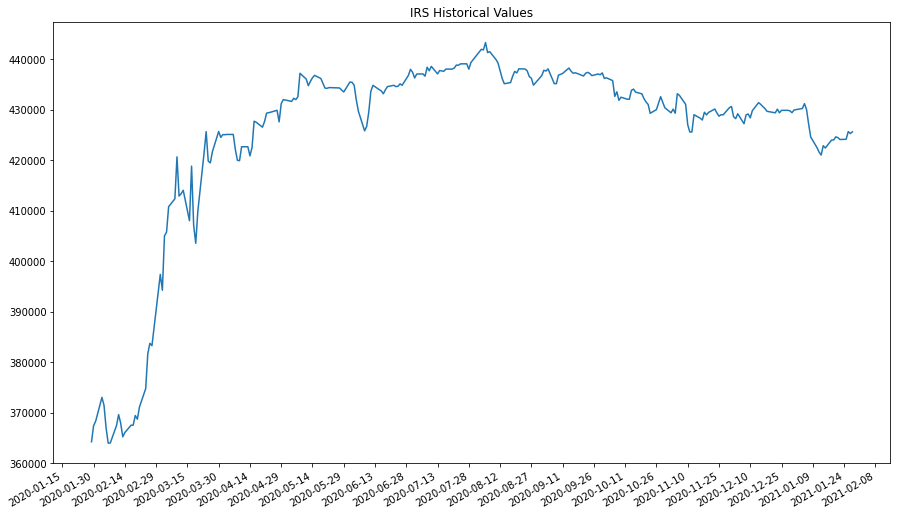

In [11]:
converted_dates = list(map(datetime.datetime.strptime, portfoliohistoricaldates, len(portfoliohistoricaldates)*['%Y-%m-%d']))
plt.figure(figsize=(15,9))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
plt.gcf().autofmt_xdate()
plt.plot(converted_dates, portfoliohistoricalvalues)
plt.title("IRS Historical Values")
current_values = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:.0f}'.format(x) for x in current_values])
plt.show()